# Exploration of the Red Sparkler

## Setup

In [5]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, LinearStretch, SqrtStretch, LogStretch, ImageNormalize
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table

from astropy.cosmology import WMAP5 as cosmo
from astropy.coordinates import Distance
from astropy import units as u

from photutils.centroids import centroid_sources, centroid_com
from photutils.segmentation import detect_threshold, detect_sources
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from photutils.aperture import aperture_photometry

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import fsps

import time
import math
import warnings

import matplotlib.pyplot as plt

import sparkly_tools as spk
import importlib
importlib.reload(spk) # Because I'm actively editing this thing!

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = [12, 8]

# Cutout the Sparky Sparkler in all the available bands

## The relevant filenames

In [6]:
input_filenames = [
"Data/smacs0723-f090w_40mas_drz_sci.fits",
"Data/smacs0723-f125w_40mas_drz_sci.fits",
"Data/smacs0723-f140w_40mas_drz_sci.fits",
"Data/smacs0723-f150w_40mas_drz_sci.fits",
"Data/smacs0723-f160w_40mas_drz_sci.fits",
"Data/smacs0723-f200w_40mas_drz_sci.fits",
"Data/smacs0723-f277w_40mas_drz_sci.fits",
"Data/smacs0723-f435w_40mas_drc_sci.fits",
"Data/smacs0723-f444w_40mas_drz_sci.fits",
"Data/smacs0723-f606w_40mas_drc_sci.fits",
"Data/smacs0723-f814w_40mas_drc_sci.fits",
]

In [7]:
cutout_filenames = [f.replace("Data","Data/Sparkles").replace("smacs0723","sparkly").replace("_40mas","")
                    for f in input_filenames]
cutout_filenames

['Data/Sparkles/sparkly-f090w_drz_sci.fits',
 'Data/Sparkles/sparkly-f125w_drz_sci.fits',
 'Data/Sparkles/sparkly-f140w_drz_sci.fits',
 'Data/Sparkles/sparkly-f150w_drz_sci.fits',
 'Data/Sparkles/sparkly-f160w_drz_sci.fits',
 'Data/Sparkles/sparkly-f200w_drz_sci.fits',
 'Data/Sparkles/sparkly-f277w_drz_sci.fits',
 'Data/Sparkles/sparkly-f435w_drc_sci.fits',
 'Data/Sparkles/sparkly-f444w_drz_sci.fits',
 'Data/Sparkles/sparkly-f606w_drc_sci.fits',
 'Data/Sparkles/sparkly-f814w_drc_sci.fits']

## Save small files each with the correct WCS

In [8]:
sparkly_coordinates = SkyCoord(110.8407337, -73.4553152, unit="deg")
sparkly_size = 250

In [9]:
for infile,outfile in zip(input_filenames,cutout_filenames):
    print('{} zp:{}'.format(infile,spk.get_zeropoint(infile)))
    spk.save_cutout(infile,sparkly_coordinates,sparkly_size,outfile)

Data/smacs0723-f090w_40mas_drz_sci.fits zp:28.010293032948354
Data/smacs0723-f125w_40mas_drz_sci.fits zp:26.2321432655919
Data/smacs0723-f140w_40mas_drz_sci.fits zp:26.45082571172386
Data/smacs0723-f150w_40mas_drz_sci.fits zp:28.010293032948354
Data/smacs0723-f160w_40mas_drz_sci.fits zp:25.93773870692516
Data/smacs0723-f200w_40mas_drz_sci.fits zp:28.010293032948354
Data/smacs0723-f277w_40mas_drz_sci.fits zp:26.476300692993007
Data/smacs0723-f435w_40mas_drc_sci.fits zp:None
Data/smacs0723-f444w_40mas_drz_sci.fits zp:26.476300692993007
Data/smacs0723-f606w_40mas_drc_sci.fits zp:None
Data/smacs0723-f814w_40mas_drc_sci.fits zp:None


## Define a master dictionary with filenames, array data, and zeropoints

In [10]:
imagedata = {}
zp = {}
stampfile = {}

filternames = [f.replace('Data/Sparkles/sparkly-','').replace('w_drz_sci.fits','').replace('w_drc_sci.fits','') for f in cutout_filenames]
zeropoints = [spk.get_zeropoint(f) for f in cutout_filenames]

for cutout_file,filtername,zeropoint in zip(cutout_filenames,filternames,zeropoints):
    imagedata[filtername] = fits.open(cutout_file)[0].data
    zp[filtername] = spk.get_zeropoint(cutout_file)
    stampfile[filtername] = cutout_file
    

# Read in the Sparkler cutout data

In [11]:
sparkly_data_variables = [f.replace('Data/Sparkles/sparkly-','').replace('w_drz_sci.fits','').replace('w_drc_sci.fits','') for f in cutout_filenames]

In [12]:
for varname,filename in zip(sparkly_data_variables,cutout_filenames):
    command = "{} = fits.open(\"{}\")[0].data".format(varname,filename)
    print("Defining {}".format(varname))
    exec(command)

Defining f090
Defining f125
Defining f140
Defining f150
Defining f160
Defining f200
Defining f277
Defining f435
Defining f444
Defining f606
Defining f814


# Display the data

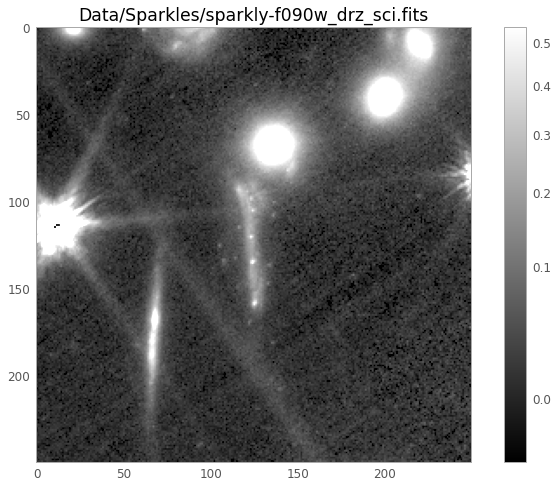

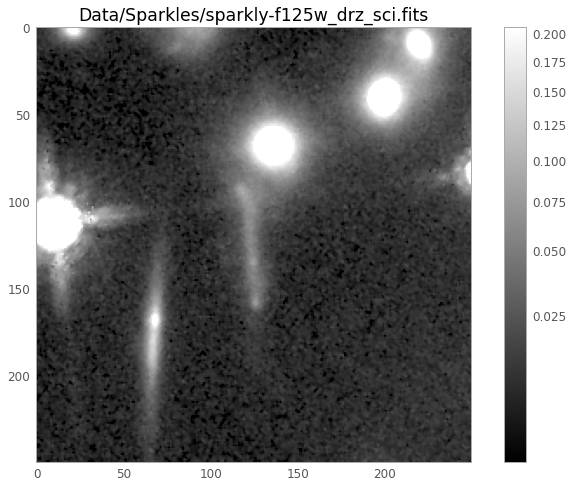

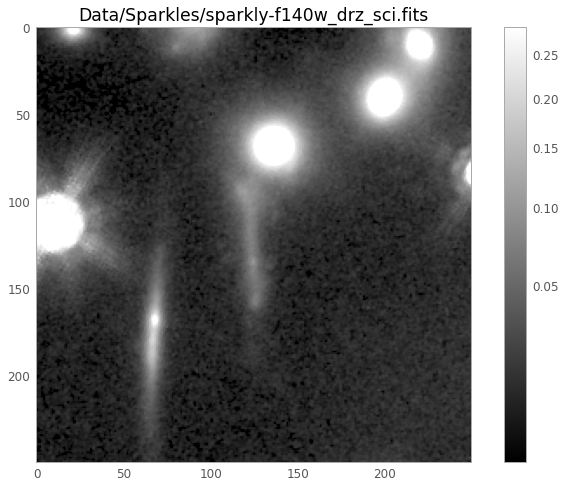

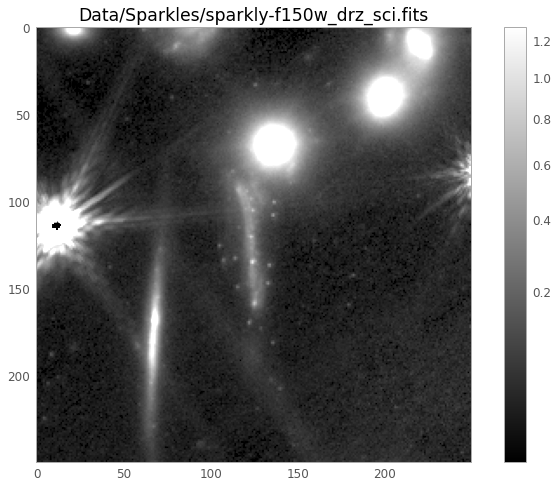

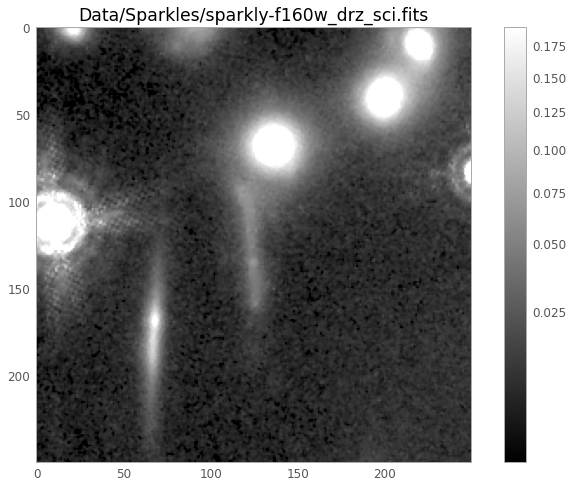

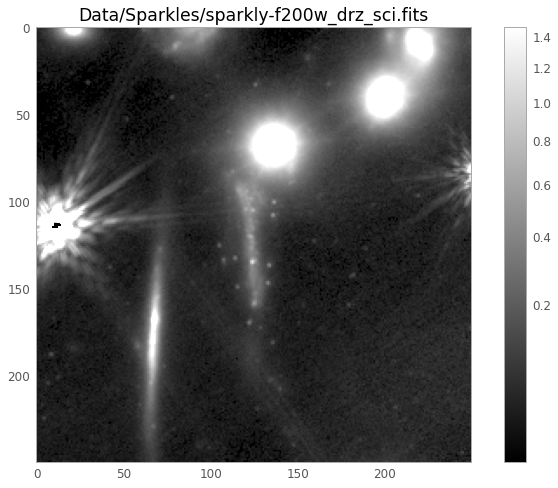

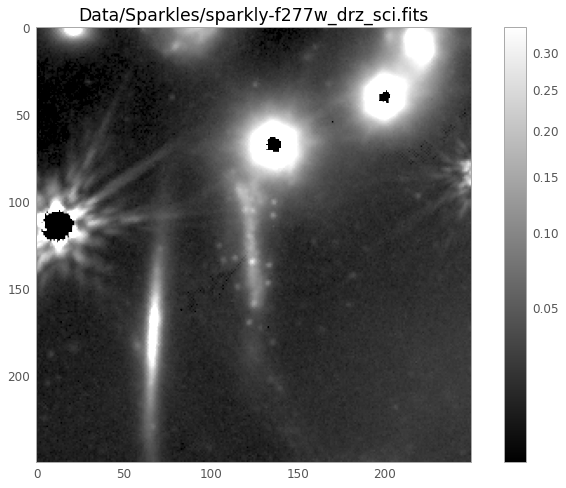

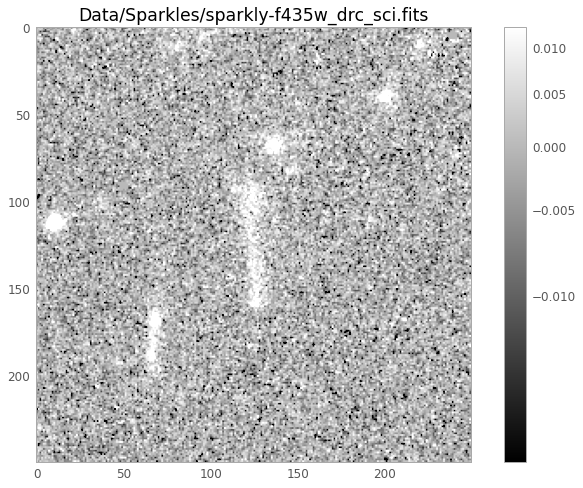

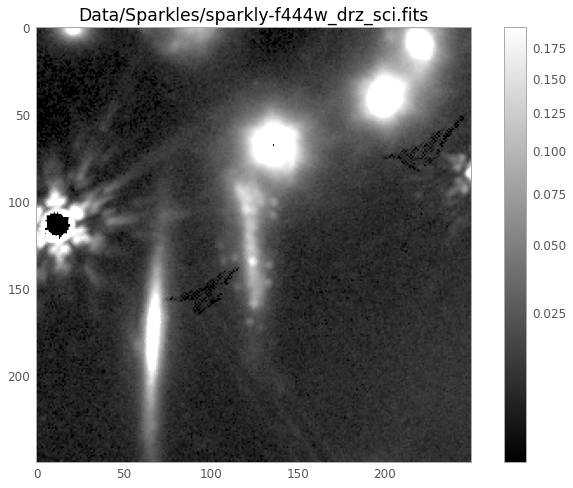

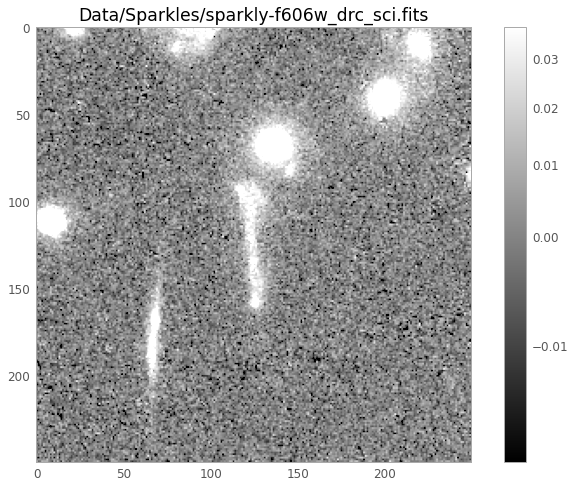

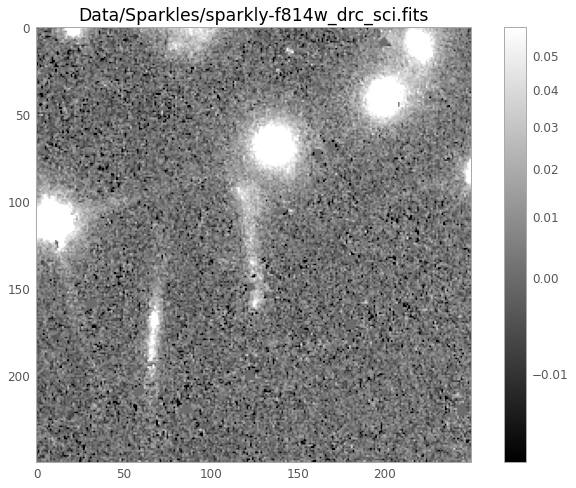

In [13]:
for filt in filternames:
    spk.display_data(imagedata[filt], title=stampfile[filt], show_colorbar=True)

# Analyze F200W data

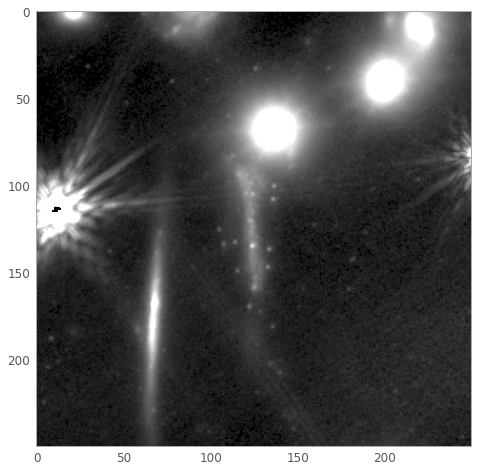

In [15]:
filter_name = 'f200'
image_file = stampfile[filter_name]
psf_file = 'Data/PSF/smacs0723-f200w_drz_sci_40masf200w_psf.fits'

spk.display_data(image_file)

Using ds9 I clicked on a bunch of things to generate a file with the sparkle positions. We will centroid around these to define the positions of the sparkles.

/home/abraham/research/CANUCS-Sparkles/sparkly_tools.py:279: RuntimeWarning: invalid value encountered in log10
  mags = zp - 2.5*np.log10(phot_table['aperture_sum'] - total_bkg)


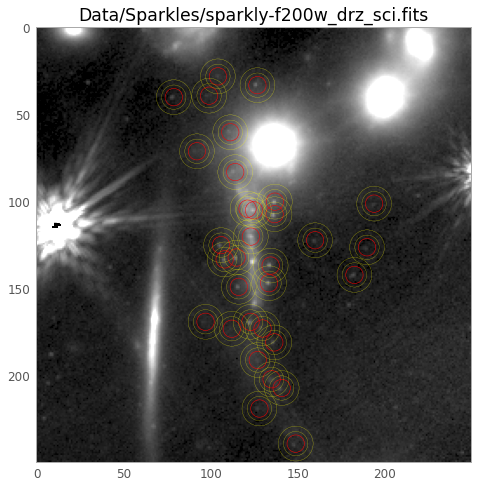

In [16]:
sparkly_positions = 'Data/Regions/sparkles.txt'

image_data = fits.getdata(image_file, ext=0)
zeropoint = 26.49
results = spk.analyze_stars(image_data, zp[filter_name], sparkly_positions, title=image_file)

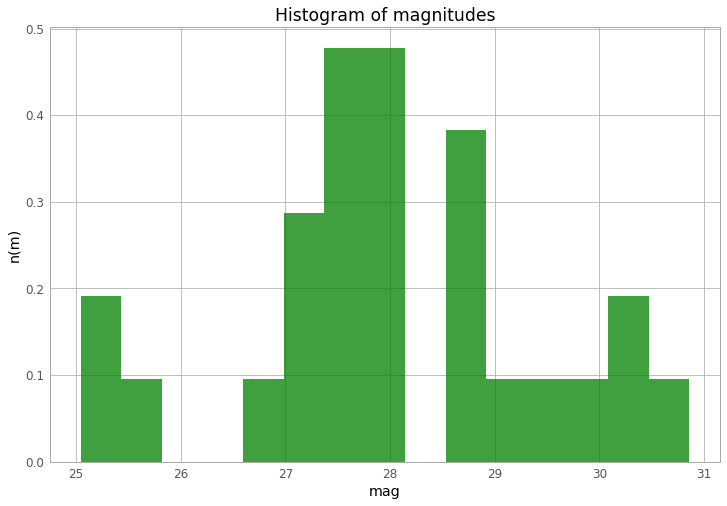

In [17]:
plt.figure()
plt.xlabel('mag')
plt.ylabel('n(m)')
plt.title('Histogram of magnitudes')
n, bins, patches = plt.hist(results['mag'].data, 15, density=True, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()

## Model the aperture correction and the uncertainties by creating and measuring fake sparkles

I identified a bunch of representative spots on image using ds9 (I just clicked on empty regions with 'c' and copy the output to a file). Now I will create fake sparkes at these positions and then analyze them.

/home/abraham/research/CANUCS-Sparkles/sparkly_tools.py:279: RuntimeWarning: invalid value encountered in log10
  mags = zp - 2.5*np.log10(phot_table['aperture_sum'] - total_bkg)


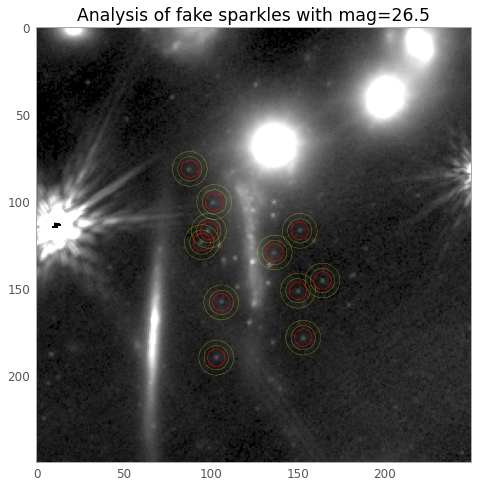

In [18]:
filter_name = 'f200'
image_file = stampfile[filter_name]
psf_file = 'Data/PSF/smacs0723-f200w_drz_sci_40masf200w_psf.fits'
empty_regions = 'Data/Regions/empty.txt'
zeropoint = 26.49
fake_sparkle_mag = 26.5

image_data = fits.getdata(image_file, ext=0)
stars = spk.create_starfield(image_file,
                        psf_file,
                        empty_regions,
                        fake_sparkle_mag,
                        zeropoint)
new_data = image_data + stars

results = spk.analyze_stars(new_data, zeropoint, 'Data/Regions/empty.txt', 
                        title='Analysis of fake sparkles with mag={}'.format(fake_sparkle_mag))

Let's look at the magnitude distribution of the fake sparkles. It is pretty clear the aperture correction is about 0.5 mag though some are off by way more.

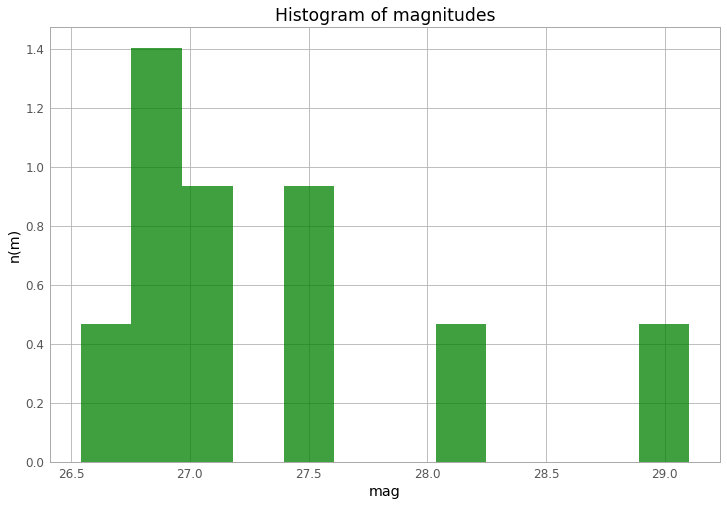

In [19]:
plt.figure()
plt.xlabel('mag')
plt.ylabel('n(m)')
plt.title('Histogram of magnitudes')
n, bins, patches = plt.hist(results['mag'].data, 12, density=True, facecolor='g', alpha=0.75)
plt.grid(True)
plt.show()

# Analysis of the colors of the sparkles

I will use F150 and F200.

/home/abraham/research/CANUCS-Sparkles/sparkly_tools.py:279: RuntimeWarning: invalid value encountered in log10
  mags = zp - 2.5*np.log10(phot_table['aperture_sum'] - total_bkg)
/home/abraham/research/CANUCS-Sparkles/sparkly_tools.py:279: RuntimeWarning: invalid value encountered in log10
  mags = zp - 2.5*np.log10(phot_table['aperture_sum'] - total_bkg)


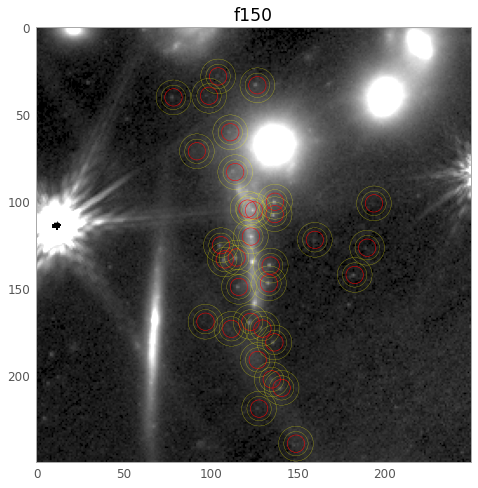

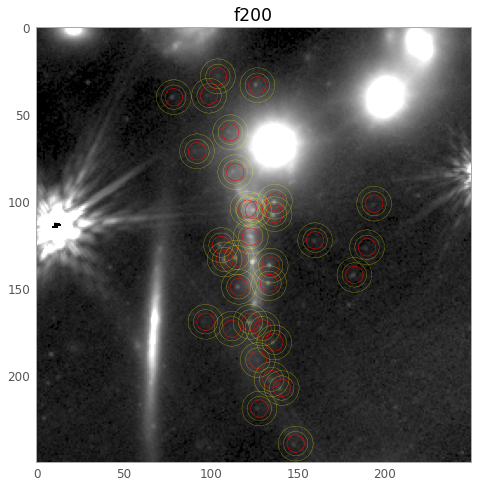

In [20]:
filternames = ['f150','f200']
image_files = [stampfile[filt] for filt in filternames]
zeropoints = [zp[filt] for filt in filternames]

photometry = Table()
for datafile,zp,colnam in zip(image_files,zeropoints,filternames):
    image_data = fits.getdata(datafile, ext=0)
    results = spk.analyze_stars(image_data, zp, 'Data/Regions/sparkles.txt', title=colnam)
    photometry[colnam] = results['mag'].data
photometry['id'] = results['id'].data
photometry['xcenter'] = results['xcenter'].data
photometry['ycenter'] = results['ycenter'].data

In [21]:
photometry.show_in_notebook()

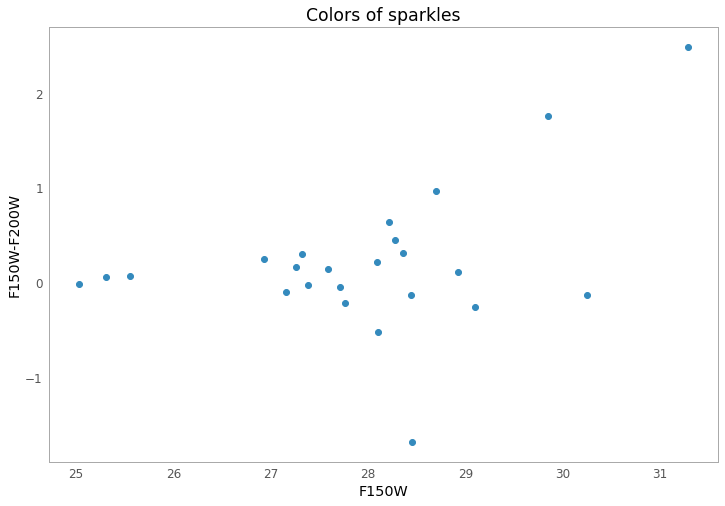

In [22]:
plt.plot(photometry['f150'],photometry['f150']-photometry['f200'],'o')
plt.xlabel('F150W')
plt.ylabel('F150W-F200W')
plt.title('Colors of sparkles');

The conclusion is that F150 - F200 is about 0 for the sparkles, more or less. What are the implications?

# Stellar population modeling

In [23]:
%%time
sp = fsps.StellarPopulation(compute_vega_mags=False, zcontinuous=0, sfh=0,
                            logzsol=-2.0, dust_type=2, dust2=0.0)

CPU times: user 11.2 s, sys: 457 ms, total: 11.6 s
Wall time: 11.8 s


In [24]:
all_jwst_bands = fsps.find_filter('jwst')
print(all_jwst_bands)

['jwst_f070w', 'jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w', 'jwst_f356w', 'jwst_f444w']


In [25]:
jwst_bands = ['jwst_f150w', 'jwst_f200w']

In [26]:
mass = 10**6
mags = sp.get_mags(tage=1.5, bands=jwst_bands, redshift=1.38) - 2.5*np.log10(mass)
color = mags[0] - mags[1]

In [27]:
mass = 5*10**6
amplification = 100

mag = []
colors = []
age_gyr = np.arange(0.1,4,0.1)
for age in age_gyr:
    mags = sp.get_mags(tage=age, bands=jwst_bands, redshift=1.38) - 2.5*np.log10(mass) - 2.5*np.log10(amplification)
    mag.append(mags[1])
    colors.append(mags[0] - mags[1])
    

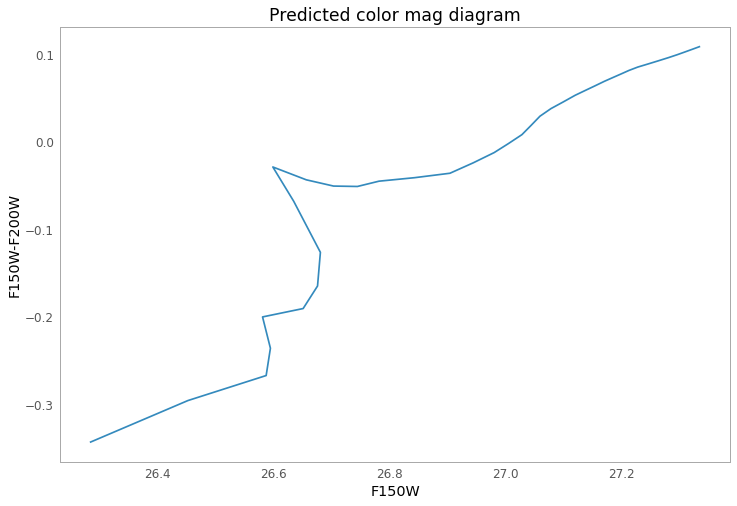

In [28]:
plt.figure()
plt.plot(mag,colors)
plt.xlabel('F150W')
plt.ylabel('F150W-F200W')
plt.title('Predicted color mag diagram');

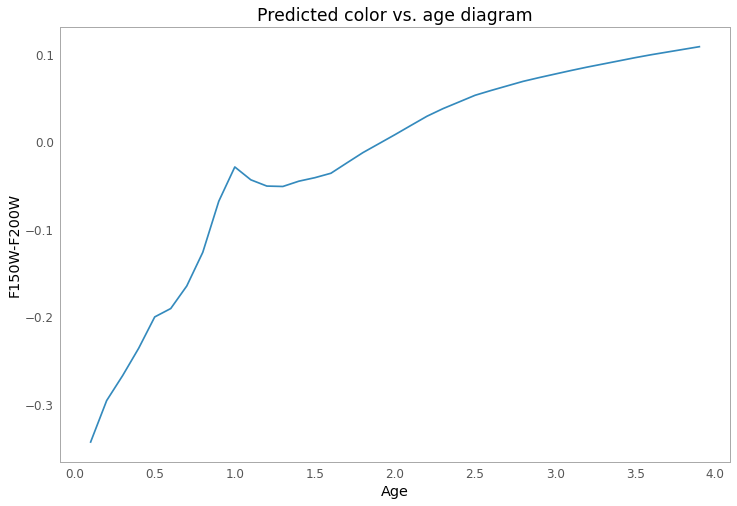

In [29]:
plt.figure()
plt.plot(age_gyr,colors)
plt.xlabel('Age')
plt.ylabel('F150W-F200W')
plt.title('Predicted color vs. age diagram');